Nhóm 1 

Trương Quang Khánh - 20170083  
Trần Minh Hiếu - 20170075  
Trương Ngọc Giang - 20170067  

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

Tạo một dataframe 

In [2]:
df = spark.read.format("json").load("../data/flight-data/json/2015-summary.json")

Dataframe là cấu trúc dữ liệu giống như table trong sql, như vậy chúng sẽ có schema tương tự như table.

In [3]:
df.printSchema()

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- count: long (nullable = true)



In [4]:
df.schema

StructType(List(StructField(DEST_COUNTRY_NAME,StringType,true),StructField(ORIGIN_COUNTRY_NAME,StringType,true),StructField(count,LongType,true)))

Một schema bao gồm nhiều trường, mỗi trường sẽ có tên, kiểu, cờ boolean thể hiện xem trường đó có thể null hay không, có thể thì cờ sẽ đặt bằng true. Ngoài ra, người dùng có thể tự định nghĩa các trường thông tin metadata chứa thông tin đặc tả cho column, thương được dùng cho thư viện machine learning của spark. 

Ví dụ dưới đây là tạo một xác định một schema cho dataframe.

In [5]:
from pyspark.sql.types import StructField, StructType, StringType, LongType
myManualSchema = StructType([
StructField("DEST_COUNTRY_NAME", StringType(), True),
StructField("ORIGIN_COUNTRY_NAME", StringType(), True),
StructField("count", LongType(), False, metadata={"hello":"world"})
])
df = spark.read.format("json").schema(myManualSchema)\
.load("../data/flight-data/json/2015-summary.json")

In [6]:
df.printSchema()

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- count: long (nullable = true)



# Columns and Expressions
## Columns
Có rất nhiều cách để tạo lên một cách diễn đạt chỉ thị cho column, trong đó ta có thể sử dụng trực tiếp hàm col hoặc column. Các hàm này sẽ trả lại một cách diễn đạt theo ngôn ngữ sql cho column tương ứng. 

In [7]:
from pyspark.sql.functions import col, column
col("someColumnName")
column("someColumnName")

Column<b'someColumnName'>

Chỉ thị trực tiếp tới cột trong dataframe 

In [8]:
df["count"]

Column<b'count'>

In [9]:
df.count

<bound method DataFrame.count of DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: bigint]>

In [10]:
(((col("someCol") + 5) * 200) - 6) < col("otherCol")

Column<b'((((someCol + 5) * 200) - 6) < otherCol)'>

# Records and Rows
Trong spark, mỗi dòng là một bản ghi

In [23]:
df.first()

Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Romania', count=15)

## Creating Rows
Có thể tạo ra dòng bằng đối tượng Row với các trường thông tin ứng với các cột

In [24]:
from pyspark.sql import Row
myRow = Row("Hello", None, 1, False)

In [25]:
myRow

<Row('Hello', None, 1, False)>

Truy cập dữ liệu của Row rất đơn giản, có thể qua index hoặc thông key giống trong từ điển.

In [26]:
myRow[0]
myRow[2]

1

# DataFrame Transformations
1. Chúng ta có thể thêm dòng và cột 
2. Chúng ta có thể xóa dòng và cột 
3. Chúng ta có thể chuyển một cột thành một dòng và ngược lại
4. Chúng ta có thể thay đổi giá trị của dòng dựa trên giá trị của cột 

 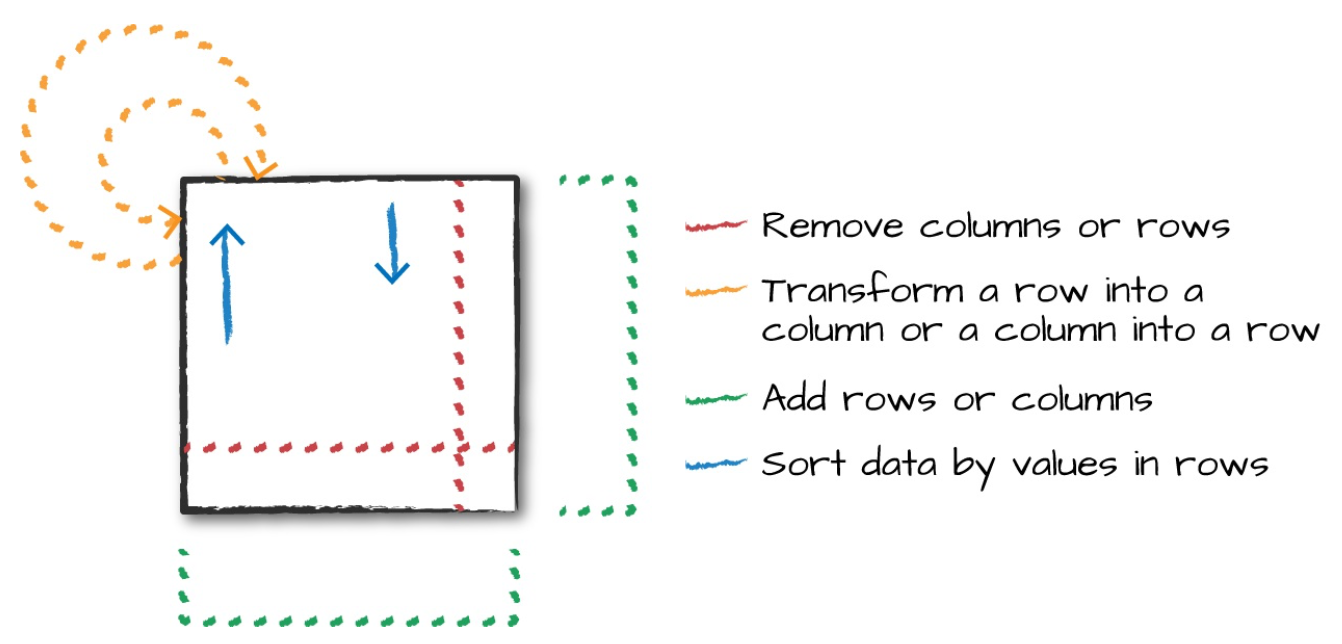

## Creating DataFrames
Chúng ta có thể tạo ra Dataframe từ nguồn raw data, có thể đăng ký nó như là view tạm thời như trong sql và đưa ra một vài biến đổi cơ bản.

In [27]:
df = spark.read.format("json").load("../data/flight-data/json/2015-summary.json")
df.createOrReplaceTempView("dfTable")

We can also create DataFrames on the fly by taking a set of rows and converting them to a
DataFrame.

In [28]:
from pyspark.sql import Row
from pyspark.sql.types import StructField, StructType, StringType, LongType
myManualSchema = StructType([
StructField("some", StringType(), True),
StructField("col", StringType(), True),
StructField("names", LongType(), False)
])
myRow = Row("Hello", None, 1)
myDf = spark.createDataFrame([myRow], myManualSchema)
myDf.show()

+-----+----+-----+
| some| col|names|
+-----+----+-----+
|Hello|null|    1|
+-----+----+-----+



## select and selectExpr
select and selectExpr cho phép thực hiện các query của sql lên dataframe tương tự như trong table của sql 

In [30]:
# in Python
df.select("DEST_COUNTRY_NAME").show(2)
#-- in SQL
#SELECT DEST_COUNTRY_NAME FROM dfTable LIMIT 2

+-----------------+
|DEST_COUNTRY_NAME|
+-----------------+
|    United States|
|    United States|
+-----------------+
only showing top 2 rows



Có thể lựa chọn nhiều cột bằng cách tương tự như truy vấn trong sql, chỉ cần thêm các tên cột tương ứng.

In [31]:
# in Python
df.select("DEST_COUNTRY_NAME", "ORIGIN_COUNTRY_NAME").show(2)
#-- in SQL
#SELECT DEST_COUNTRY_NAME, ORIGIN_COUNTRY_NAME FROM dfTable LIMIT 2

+-----------------+-------------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|
+-----------------+-------------------+
|    United States|            Romania|
|    United States|            Croatia|
+-----------------+-------------------+
only showing top 2 rows



Như được bàn luận bên trên, ta có thể thao tác trên cột bằng nhiều cách khác nhau, cần nhớ rằng nên sử dụng chúng trong hoàn cảnh thích hợp.

In [32]:
# in Python
from pyspark.sql.functions import expr, col, column
df.select(
expr("DEST_COUNTRY_NAME"),
col("DEST_COUNTRY_NAME"),
column("DEST_COUNTRY_NAME"))\
.show(2)

+-----------------+-----------------+-----------------+
|DEST_COUNTRY_NAME|DEST_COUNTRY_NAME|DEST_COUNTRY_NAME|
+-----------------+-----------------+-----------------+
|    United States|    United States|    United States|
|    United States|    United States|    United States|
+-----------------+-----------------+-----------------+
only showing top 2 rows



Expr là các thực hiện truy vấn trên dataframe linh hoạt nhất có thể dùng. Nó có thể chỉ tới một cột hoặc đưa ra một thao tác lên cột. Để minh họa, ta sẽ thay đổi tên cột và đổi lại tên bằng từ khóa AS tương tự phương thức alias.

In [33]:
# in Python
df.select(expr("DEST_COUNTRY_NAME AS destination")).show(2)
#-- in SQL
#SELECT DEST_COUNTRY_NAME as destination FROM dfTable LIMIT 2

+-------------+
|  destination|
+-------------+
|United States|
|United States|
+-------------+
only showing top 2 rows



The preceding operation changes the column name back to its original name.
Các toán tự trước đó có thể đổi tên cột.

In [34]:
df.select(expr("DEST_COUNTRY_NAME as destination").alias("DEST_COUNTRY_NAME"))\
.show(2)

+-----------------+
|DEST_COUNTRY_NAME|
+-----------------+
|    United States|
|    United States|
+-----------------+
only showing top 2 rows



Bởi vì sử dụng chuỗi expr là một mẫu chung, Spark hỗ trợ chúng một cách hiệu quả, là selectExpr. Nó có lễ là interface tiện lợi nhất được hay dùng:

In [37]:
df.selectExpr("DEST_COUNTRY_NAME as newColumnName", "DEST_COUNTRY_NAME").show(2)

+-------------+-----------------+
|newColumnName|DEST_COUNTRY_NAME|
+-------------+-----------------+
|United States|    United States|
|United States|    United States|
+-------------+-----------------+
only showing top 2 rows



Dưới đây thể hiện khả năng mạnh mẽ của Spark. Chúng ta có thể coi selectExpr như một cách đơn giản để tạo ra một query phức tạp để tạo ra một DataFrame mới. Thực tế, chúng ta có thể thêm vào nhiều câu lệnh Sql, miễn là Spark có thể phân giải được câu lệnh đó. Đây là một ví dụ đơn giản để thêm một cột mới vào dataframe bằng toán tử so sánh và đổi tên cho nó. 

In [38]:
# in Python
df.selectExpr(
"*", # all original columns
"(DEST_COUNTRY_NAME = ORIGIN_COUNTRY_NAME) as withinCountry")\
.show(2)
#-- in SQL
#SELECT *, (DEST_COUNTRY_NAME = ORIGIN_COUNTRY_NAME) as withinCountry
#FROM dfTable
#LIMIT 2

+-----------------+-------------------+-----+-------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|withinCountry|
+-----------------+-------------------+-----+-------------+
|    United States|            Romania|   15|        false|
|    United States|            Croatia|    1|        false|
+-----------------+-------------------+-----+-------------+
only showing top 2 rows



Với select, chúng ta có thể thực hiện các toán tử kết tập trên toàn bộ DataFrame nhờ lợi ích của các hàm do Spark cung cấp.

In [39]:
# in Python
df.selectExpr("avg(count)", "count(distinct(DEST_COUNTRY_NAME))").show(2)
#-- in SQL
#SELECT avg(count), count(distinct(DEST_COUNTRY_NAME)) FROM dfTable LIMIT 2

+-----------+---------------------------------+
| avg(count)|count(DISTINCT DEST_COUNTRY_NAME)|
+-----------+---------------------------------+
|1770.765625|                              132|
+-----------+---------------------------------+



## Converting to Spark Types (Literals)
Sometimes, we need to pass explicit values into Spark that are just a value (rather than a new
column). This might be a constant value or something we’ll need to compare to later on. The
way we do this is through literals. This is basically a translation from a given programming
language’s literal value to one that Spark understands. Literals are expressions and you can use
them in the same way:

Thi thoảng, chúng ta cần đưa vào DataFrame giá trị cụ thể. Nó có thể là hằng số hoặc giá trị mà ta cần so sánh sau đó. Cách mà chúng ta thực hiện là thông qua hàm lit. Nó là cách biến đổi cơ bản từ một giá trị cụ thể để spark có thể hiểu được. 

In [42]:
# in Python
from pyspark.sql.functions import lit
df.select(expr("*"), lit(1).alias("One")).show(2)

#In SQL, literals are just the specific value:
#-- in SQL
#SELECT *, 1 as One FROM dfTable LIMIT 2

+-----------------+-------------------+-----+---+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|One|
+-----------------+-------------------+-----+---+
|    United States|            Romania|   15|  1|
|    United States|            Croatia|    1|  1|
+-----------------+-------------------+-----+---+
only showing top 2 rows



## Adding Columns
There’s also a more formal way of adding a new column to a DataFrame, and that’s by using the
withColumn method on our DataFrame. For example, let’s add a column that just adds the
number one as a column:

Còn có nhiều hơn cách trên để thêm một cột mới, bằng hàm withColumn.

In [43]:
# in Python
df.withColumn("numberOne", lit(1)).show(2)
#-- in SQL
#SELECT *, 1 as numberOne FROM dfTable LIMIT 2

+-----------------+-------------------+-----+---------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|numberOne|
+-----------------+-------------------+-----+---------+
|    United States|            Romania|   15|        1|
|    United States|            Croatia|    1|        1|
+-----------------+-------------------+-----+---------+
only showing top 2 rows



Let’s do something a bit more interesting and make it an actual expression. In the next example,
we’ll set a Boolean flag for when the origin country is the same as the destination country:

Đặt một flag thể hiện 2 cột bằng nhau của country

In [44]:
# in Python
df.withColumn("withinCountry", expr("ORIGIN_COUNTRY_NAME == DEST_COUNTRY_NAME"))\
.show(2)

+-----------------+-------------------+-----+-------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|withinCountry|
+-----------------+-------------------+-----+-------------+
|    United States|            Romania|   15|        false|
|    United States|            Croatia|    1|        false|
+-----------------+-------------------+-----+-------------+
only showing top 2 rows



Notice that the withColumn function takes two arguments: the column name and the expression
that will create the value for that given row in the DataFrame. Interestingly, we can also rename
a column this way. The SQL syntax is the same as we had previously, so we can omit it in this
example:

Chú ý rằng withColumn có 2 tham số: tên và các tạo ra chúng từ các cột của DataFrame.
Ta có thể đổi tên cột bằng cách này. 

In [45]:
df.withColumn("Destination", expr("DEST_COUNTRY_NAME")).columns

['DEST_COUNTRY_NAME', 'ORIGIN_COUNTRY_NAME', 'count', 'Destination']

## Renaming Columns
Although we can rename a column in the manner that we just described, another alternative is to
use the withColumnRenamed method. This will rename the column with the name of the string in
the first argument to the string in the second argument:

Mặc dù chúng ta có thể đổi tên cột bằng nhiều cách, một cách khác là sử dụng phương thức withFunctionRenamed

In [46]:
# in Python
df.withColumnRenamed("DEST_COUNTRY_NAME", "dest").columns

['dest', 'ORIGIN_COUNTRY_NAME', 'count']

## Reserved Characters and Keywords
One thing that you might come across is reserved characters like spaces or dashes in column
names. Handling these means escaping column names appropriately. In Spark, we do this by
using backtick (`) characters. Let’s use withColumn, which you just learned about to create a
column with reserved characters. We’ll show two examples—in the one shown here, we don’t
need escape characters, but in the next one, we do:

Nhiều khi ta cần có "" để thể hiện tên của cột. Trong spark, ta sẽ dùng ` để thay thế cho "

In [47]:
# in Python
dfWithLongColName = df.withColumn(
"This Long Column-Name",
expr("ORIGIN_COUNTRY_NAME"))

We don’t need escape characters here because the first argument to withColumn is just a string
for the new column name. In this example, however, we need to use backticks because we’re
referencing a column in an expression:

Chúng ta không cần thiết thoát các ký tự ở đây bởi vì tham số đầu tiên là một string bình thường cho tên cột. Trường hợp sau đây cần `

In [49]:
dfWithLongColName.selectExpr(
"`This Long Column-Name`",
"`This Long Column-Name` as `new col`")\
.show(2)
dfWithLongColName.createOrReplaceTempView("dfTableLong")
#-- in SQL
#SELECT `This Long Column-Name`, `This Long Column-Name` as `new col`
#FROM dfTableLong LIMIT 2

+---------------------+-------+
|This Long Column-Name|new col|
+---------------------+-------+
|              Romania|Romania|
|              Croatia|Croatia|
+---------------------+-------+
only showing top 2 rows



We can refer to columns with reserved characters (and not escape them) if we’re doing an
explicit string-to-column reference, which is interpreted as a literal instead of an expression. We
only need to escape expressions that use reserved characters or keywords. The following two
examples both result in the same DataFrame:

Chúng ta có thể chỉ đến cột với ký tự bảo lưu nếu truy vấn chúng ta chỉ tớ nó một cách rõ ràng. 

In [1]:
# in Python
dfWithLongColName.select(expr("`This Long Column-Name`")).columns

NameError: name 'dfWithLongColName' is not defined

## Removing Columns
Now that we’ve created this column, let’s take a look at how we can remove columns from
DataFrames. You likely already noticed that we can do this by using select. However, there is
also a dedicated method called drop:

In [52]:
df.drop("ORIGIN_COUNTRY_NAME").columns

['DEST_COUNTRY_NAME', 'count']

We can drop multiple columns by passing in multiple columns as arguments:
Ta có thể loại bỏ nhiều cột của DataFrame

In [53]:
dfWithLongColName.drop("ORIGIN_COUNTRY_NAME", "DEST_COUNTRY_NAME")

DataFrame[count: bigint, This Long Column-Name: string]

## Changing a Column’s Type (cast)
Sometimes, we might need to convert from one type to another; for example, if we have a set of
StringType that should be integers. We can convert columns from one type to another by
casting the column from one type to another. For instance, let’s convert our count column from
an integer to a type Long:

Thi thoảng, chúng ta cần đổi kiểu cho cột. 

In [56]:
df.withColumn("count2", col("count").cast("long"))
#-- in SQL
#SELECT *, cast(count as long) AS count2 FROM dfTable

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: bigint, count2: bigint]

## Filtering Rows
To filter rows, we create an expression that evaluates to true or false. You then filter out the rows
with an expression that is equal to false. The most common way to do this with DataFrames is to
create either an expression as a String or build an expression by using a set of column
manipulations. There are two methods to perform this operation: you can use where or filter
and they both will perform the same operation and accept the same argument types when used
with DataFrames. We will stick to where because of its familiarity to SQL; however, filter is
valid as well.

Để thực hiện filter trên DataFrame, chúng ta sử dụng cách diễn đạt của ngôn ngữ sql, hoặc sự dùng các hàm trong module functions để thực hiện chuyển đổi chúng. 

In [57]:
#The following filters are equivalent, and the results are the same in Scala and Python:
df.filter(col("count") < 2).show(2)
df.where("count < 2").show(2)
#-- in SQL
#SELECT * FROM dfTable WHERE count < 2 LIMIT 2

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Croatia|    1|
|    United States|          Singapore|    1|
+-----------------+-------------------+-----+
only showing top 2 rows

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Croatia|    1|
|    United States|          Singapore|    1|
+-----------------+-------------------+-----+
only showing top 2 rows



Instinctually, you might want to put multiple filters into the same expression. Although this is
possible, it is not always useful, because Spark automatically performs all filtering operations at
the same time regardless of the filter ordering. This means that if you want to specify multiple
AND filters, just chain them sequentially and let Spark handle the rest:

Một cách khác, bạn muốn đặt nhiều filter vào cùng một truy vấn.

In [58]:
# in Python
df.where(col("count") < 2).where(col("ORIGIN_COUNTRY_NAME") != "Croatia")\
.show(2)
#-- in SQL
#SELECT * FROM dfTable WHERE count < 2 AND ORIGIN_COUNTRY_NAME != "Croatia"
#LIMIT 2

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|          Singapore|    1|
|          Moldova|      United States|    1|
+-----------------+-------------------+-----+
only showing top 2 rows



## Getting Unique Rows
A very common use case is to extract the unique or distinct values in a DataFrame. These values
can be in one or more columns. The way we do this is by using the distinct method on a
DataFrame, which allows us to deduplicate any rows that are in that DataFrame. For instance,
let’s get the unique origins in our dataset. This, of course, is a transformation that will return a
new DataFrame with only unique rows:

Để thực hiện lấy các giá trị không trùng lặp, ta sử dùng phương thức distinct

In [59]:
# in Python
df.select("ORIGIN_COUNTRY_NAME", "DEST_COUNTRY_NAME").distinct().count()
#-- in SQL
#SELECT COUNT(DISTINCT(ORIGIN_COUNTRY_NAME, DEST_COUNTRY_NAME)) FROM dfTable

256

In [61]:
# in Python
df.select("ORIGIN_COUNTRY_NAME").distinct().count()
#-- in SQL
#SELECT COUNT(DISTINCT ORIGIN_COUNTRY_NAME) FROM dfTable

125

## Random Samples
Sometimes, you might just want to sample some random records from your DataFrame. You can
do this by using the sample method on a DataFrame, which makes it possible for you to specify
a fraction of rows to extract from a DataFrame and whether you’d like to sample with or without
replacement:

Thực hiện lấy ngẫu nhiên các dòng của dataframe bằng hàm sample 

In [62]:
# in Python
seed = 5
withReplacement = False
fraction = 0.5
df.sample(withReplacement, fraction, seed).count()

138

## Random Splits
Random splits can be helpful when you need to break up your DataFrame into a random “splits”
of the original DataFrame. This is often used with machine learning algorithms to create training,
validation, and test sets. In this next example, we’ll split our DataFrame into two different
DataFrames by setting the weights by which we will split the DataFrame (these are the
arguments to the function). Because this method is designed to be randomized, we will also
specify a seed (just replace seed with a number of your choosing in the code block). It’s
important to note that if you don’t specify a proportion for each DataFrame that adds up to one,
they will be normalized so that they do:

In [63]:
# in Python
dataFrames = df.randomSplit([0.25, 0.75], seed)
dataFrames[0].count() > dataFrames[1].count() # False

False

## Concatenating and Appending Rows (Union)
As you learned in the previous section, DataFrames are immutable. This means users cannot
append to DataFrames because that would be changing it. To append to a DataFrame, you must
union the original DataFrame along with the new DataFrame. This just concatenates the two
DataFramess. To union two DataFrames, you must be sure that they have the same schema and
number of columns; otherwise, the union will fail.

Ta có thể hợp các DataFrame


In [66]:
# in Python
from pyspark.sql import Row
schema = df.schema
newRows = [
Row("New Country", "Other Country", 5),
Row("New Country 2", "Other Country 3", 1)
]
parallelizedRows = spark.sparkContext.parallelize(newRows)
newDF = spark.createDataFrame(parallelizedRows, schema)
# in Python
df.union(newDF)\
.where("count = 1")\
.where(col("ORIGIN_COUNTRY_NAME") != "United States")\
.show()

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Croatia|    1|
|    United States|          Singapore|    1|
|    United States|          Gibraltar|    1|
|    United States|             Cyprus|    1|
|    United States|            Estonia|    1|
|    United States|          Lithuania|    1|
|    United States|           Bulgaria|    1|
|    United States|            Georgia|    1|
|    United States|            Bahrain|    1|
|    United States|   Papua New Guinea|    1|
|    United States|         Montenegro|    1|
|    United States|            Namibia|    1|
|    New Country 2|    Other Country 3|    1|
+-----------------+-------------------+-----+



## Sorting Rows
When we sort the values in a DataFrame, we always want to sort with either the largest or
smallest values at the top of a DataFrame. There are two equivalent operations to do this sort
and orderBy that work the exact same way. They accept both column expressions and strings as
well as multiple columns. The default is to sort in ascending order:

Ngoài ra còn có thể sắp xếp lại DataFrame theo thứ tự tăng hoặc giảm của cột 

In [2]:
# in Python
df.sort("count").show(5)
df.orderBy("count", "DEST_COUNTRY_NAME").show(5)
df.orderBy(col("count"), col("DEST_COUNTRY_NAME")).show(5)

NameError: name 'df' is not defined

To more explicitly specify sort direction, you need to use the asc and desc functions if operating
on a column. These allow you to specify the order in which a given column should be sorted:

Để thực hiện cụ thể hơn, ta có thể chọn thứ tự giá trị của cột. 

In [68]:
# in Python
from pyspark.sql.functions import desc, asc
df.orderBy(expr("count desc")).show(2)
df.orderBy(col("count").desc(), col("DEST_COUNTRY_NAME").asc()).show(2)
#-- in SQL
#SELECT * FROM dfTable ORDER BY count DESC, DEST_COUNTRY_NAME ASC LIMIT 2

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|          Moldova|      United States|    1|
|    United States|            Croatia|    1|
+-----------------+-------------------+-----+
only showing top 2 rows

+-----------------+-------------------+------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME| count|
+-----------------+-------------------+------+
|    United States|      United States|370002|
|    United States|             Canada|  8483|
+-----------------+-------------------+------+
only showing top 2 rows



An advanced tip is to use asc_nulls_first, desc_nulls_first, asc_nulls_last, or
desc_nulls_last to specify where you would like your null values to appear in an ordered
DataFrame.
For optimization purposes, it’s sometimes advisable to sort within each partition before another
set of transformations. You can use the sortWithinPartitions method to do this:

In [70]:
# in Python
spark.read.format("json").load("../data/flight-data/json/*-summary.json")\
.sortWithinPartitions("count")

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: bigint]

## Limit
Oftentimes, you might want to restrict what you extract from a DataFrame; for example, you
might want just the top ten of some DataFrame. You can do this by using the limit method:

In [71]:
# in Python
df.limit(5).show()
#-- in SQL
#SELECT * FROM dfTable LIMIT 6

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Croatia|    1|
|    United States|            Ireland|  344|
|            Egypt|      United States|   15|
|    United States|              India|   62|
+-----------------+-------------------+-----+



In [72]:
# in Python
df.orderBy(expr("count desc")).limit(6).show()
#-- in SQL
#SELECT * FROM dfTable ORDER BY count desc LIMIT 6

+--------------------+-------------------+-----+
|   DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+--------------------+-------------------+-----+
|               Malta|      United States|    1|
|Saint Vincent and...|      United States|    1|
|       United States|            Croatia|    1|
|       United States|          Gibraltar|    1|
|       United States|          Singapore|    1|
|             Moldova|      United States|    1|
+--------------------+-------------------+-----+



## Repartition and Coalesce
Another important optimization opportunity is to partition the data according to some frequently
filtered columns, which control the physical layout of data across the cluster including the
partitioning scheme and the number of partitions.

Repartition will incur a full shuffle of the data, regardless of whether one is necessary. This
means that you should typically only repartition when the future number of partitions is greater
than your current number of partitions or when you are looking to partition by a set of columns:

Một phần tối ưu quan trọng khác là thực hiện partition data dựa theo phổ biển của các cột được filter. 

In [73]:
# in Python
df.rdd.getNumPartitions() # 1

1

In [78]:
# in Python
df.repartition(5)

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: bigint]

If you know that you’re going to be filtering by a certain column often, it can be worth
repartitioning based on that column:

In [79]:
# in Python
df.repartition(col("DEST_COUNTRY_NAME"))

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: bigint]

You can optionally specify the number of partitions you would like, too:

In [80]:
# in Python
df.repartition(5, col("DEST_COUNTRY_NAME"))

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: bigint]

Coalesce, on the other hand, will not incur a full shuffle and will try to combine partitions. This
operation will shuffle your data into five partitions based on the destination country name, and
then coalesce them (without a full shuffle):

In [81]:
# in Python
df.repartition(5, col("DEST_COUNTRY_NAME")).coalesce(2)

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: bigint]

## Collecting Rows to the Driver
As discussed in previous chapters, Spark maintains the state of the cluster in the driver. There are
times when you’ll want to collect some of your data to the driver in order to manipulate it on
your local machine.

Thus far, we did not explicitly define this operation. However, we used several different methods
for doing so that are effectively all the same. collect gets all data from the entire DataFrame,
take selects the first N rows, and show prints out a number of rows nicely.

Như được bàn luận ở chapter trước, Spark bảo trì trạng thái của cụm trong chương trình thực thi. Có nhiều khi ta muôn thu thập nhiều dữ liệu bao gồm cả dữ liệu của driver để thực hiện xử lý trên máy tính của bạn. 
Như vậy, chúng ta không thực hiện trực tiếp toán tử, nhưng có thể dùng vài phương thức khác tương tự. 

In [82]:
# in Python
collectDF = df.limit(10)
collectDF.take(5) # take works with an Integer count
collectDF.show() # this prints it out nicely
collectDF.show(5, False)
collectDF.collect()

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Croatia|    1|
|    United States|            Ireland|  344|
|            Egypt|      United States|   15|
|    United States|              India|   62|
|    United States|          Singapore|    1|
|    United States|            Grenada|   62|
|       Costa Rica|      United States|  588|
|          Senegal|      United States|   40|
|          Moldova|      United States|    1|
+-----------------+-------------------+-----+

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|United States    |Romania            |15   |
|United States    |Croatia            |1    |
|United States    |Ireland            |344  |
|Egypt            |United States      |15   |
|United States    |India         

[Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Romania', count=15),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Croatia', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Ireland', count=344),
 Row(DEST_COUNTRY_NAME='Egypt', ORIGIN_COUNTRY_NAME='United States', count=15),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='India', count=62),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Singapore', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Grenada', count=62),
 Row(DEST_COUNTRY_NAME='Costa Rica', ORIGIN_COUNTRY_NAME='United States', count=588),
 Row(DEST_COUNTRY_NAME='Senegal', ORIGIN_COUNTRY_NAME='United States', count=40),
 Row(DEST_COUNTRY_NAME='Moldova', ORIGIN_COUNTRY_NAME='United States', count=1)]

There’s an additional way of collecting rows to the driver in order to iterate over the entire
dataset. The method toLocalIterator collects partitions to the driver as an iterator. This
method allows you to iterate over the entire dataset partition-by-partition in a serial manner:

In [83]:
collectDF.toLocalIterator()

<generator object _local_iterator_from_socket.<locals>.PyLocalIterable.__iter__ at 0x7f0796b62820>

# Conclusion
This chapter covered basic operations on DataFrames. You learned the simple concepts and tools
that you will need to be successful with Spark DataFrames. Chapter 6 covers in much greater
detail all of the different ways in which you can manipulate the data in those DataFrames.